##### Setup Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

##### Initialise functions

In [2]:
def hist_plot(title, columns, colours, nrows, ncols, index_pos, left=0.125, top=0.9, bottom=0.1, right=0.9, wspace=0.3, hspace=0.7):
    """
    Plots a histogram.
    :param title:     The title of the histogram.
    :param columns:   The data columns to plot on the histogram.
    :param colours:   The colours for each data column on the histogram.
    :param nrows:     The number of rows in the presentation table.
    :param ncols:     The number of columns in the presentation table.
    :param index_pos: The index of the histogram on the
    :param left:      How far to move away from left.
    :param top:       How far to move away from top.
    :param bottom:    How far to extend towards bottom.
    :param right:     How far to extend boundary towards right.
    :param wspace:    Height ratio spacing between plots.
    :param hspace:    Width ratio spacing between plots.
    :return:
    """
    plt.subplot(nrows,ncols,index_pos)
    plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)
    for index_pos, column in enumerate(columns):
        plt.hist(column, alpha=0.3, color=colours[index_pos % len(colours)], density=True)
    plt.title(title)
    plt.xticks(rotation='vertical')

def classify_length_of_stay(length_of_stay):
    """
    Classifies length of stay into Class 0 if its < 4 days, or Class 1 otherwise.
    :param length_of_stay: The number of days stayed at hospital.
    :return: integer 0 or 1, representing class 0 or class 1.
    """
    return 0 if length_of_stay < 4 else 1

In [3]:
# Load the dataset
dataFrame = pd.read_csv('./data/train_data.csv', delimiter=',')
dataFrame.head()

,ID,HealthServiceArea,Gender,Race,TypeOfAdmission,CCSProcedureCode,APRSeverityOfIllnessCode,PaymentTypology,BirthWeight,EmergencyDepartmentIndicator,AverageCostInCounty,AverageChargesInCounty,AverageCostInFacility,AverageChargesInFacility,AverageIncomeInZipCode,LengthOfStay
0,1,New York City,F,Other Race,Newborn,228,1,Medicaid,3700,N,2611,9227,1751,8951,45,1
1,2,New York City,M,Black/African American,Newborn,228,1,Medicaid,2900,N,3242,8966,3338,6409,34,1
2,3,New York City,M,Other Race,Newborn,220,1,Private Health Insurance,3200,N,3155,11381,4980,9323,45,1
3,4,New York City,F,Other Race,Newborn,0,1,Private Health Insurance,3300,N,3155,11381,5826,15680,59,1
4,5,New York City,F,Other Race,Newborn,228,1,Medicaid,2600,N,2611,9227,6000,14344,59,1


In [4]:
# Drop non-attribute columns and target column Y to form a new dataframe.
patients_X = dataFrame.drop(['ID', 'HealthServiceArea', 'LengthOfStay'], axis=1)

In [5]:
# Assign column 'LengthOfStay' to Y target.
patients_Y = np.array(list(map(classify_length_of_stay, dataFrame['LengthOfStay'])))

# Exploratory Data Analysis

### Data Fields

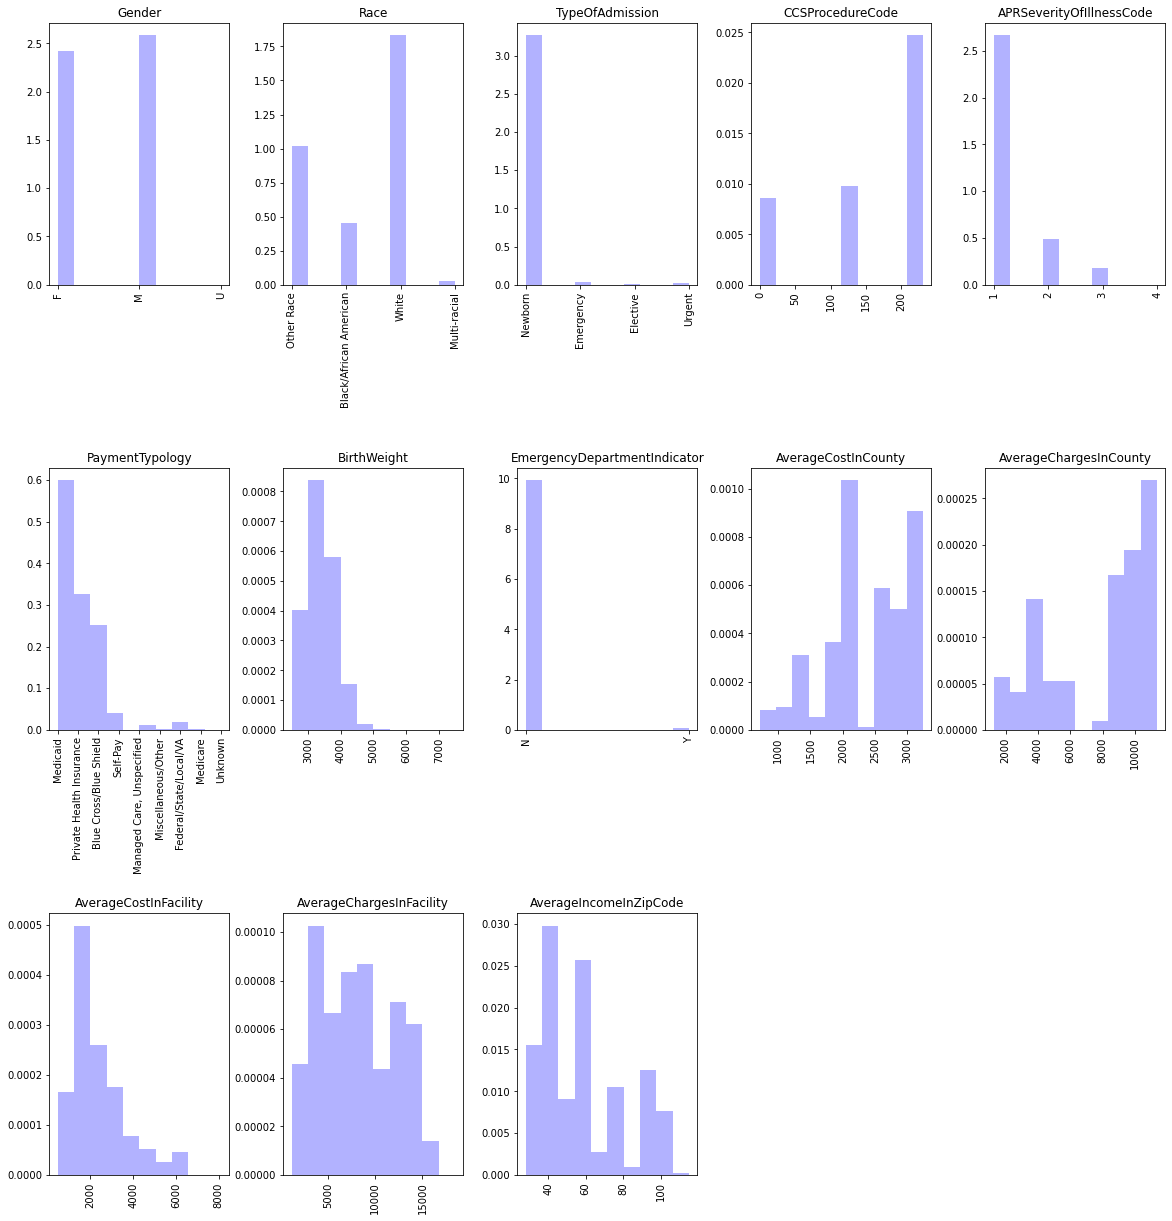

In [6]:
plt.figure(figsize=(20,20))
for i, col in enumerate(patients_X.columns):
    hist_plot(col, [patients_X[col]], ['b'], 3, 5, i+1)


> <span style="font-size:1em;">✔</span> **Observations:**
> - The types of data observed:
>
| Column Name                  |      Data Type
|------------------------------|----------------------
| Gender                       |  Nominal Categorical
| Race                         |  Nominal Categorical
| TypeOfAdmission              |  Nominal Categorical
| CCSProcedureCode             |  Nominal Categorical
| APRSeverityOfIllnessCode     |  Ordinal Categorical
| PaymentTypology              |  Nominal Categorical
| BirthWeight                  |  Continuous Numerical
| EmergencyDepartmentIndicator |  Nominal Categorical
| AverageCostInCounty          |  Discrete Numerical
| AverageChargesInCounty       |  Discrete Numerical
| AverageCostInFacility        |  Discrete Numerical
| AverageChargesInFacility     |  Discrete Numerical
| AverageIncomeInZipCode       |  Discrete Numerical
| LengthOfStay (days)          |  Discrete Numerical
> - The current data set contains features/fields that contain 'string' values.
These features are categorical and need a numerical representation in the dataset in order to help normalise the data later.
These non numerical fields are:
    - Gender
    - Race
    - TypeOfAdmission
    - PaymentTypology
    - EmergencyDepartmentIndicator

#### Classifying the data into numerical values
None of the categorical fields were ordinal, and so the np.unique() function was only needed to transform.

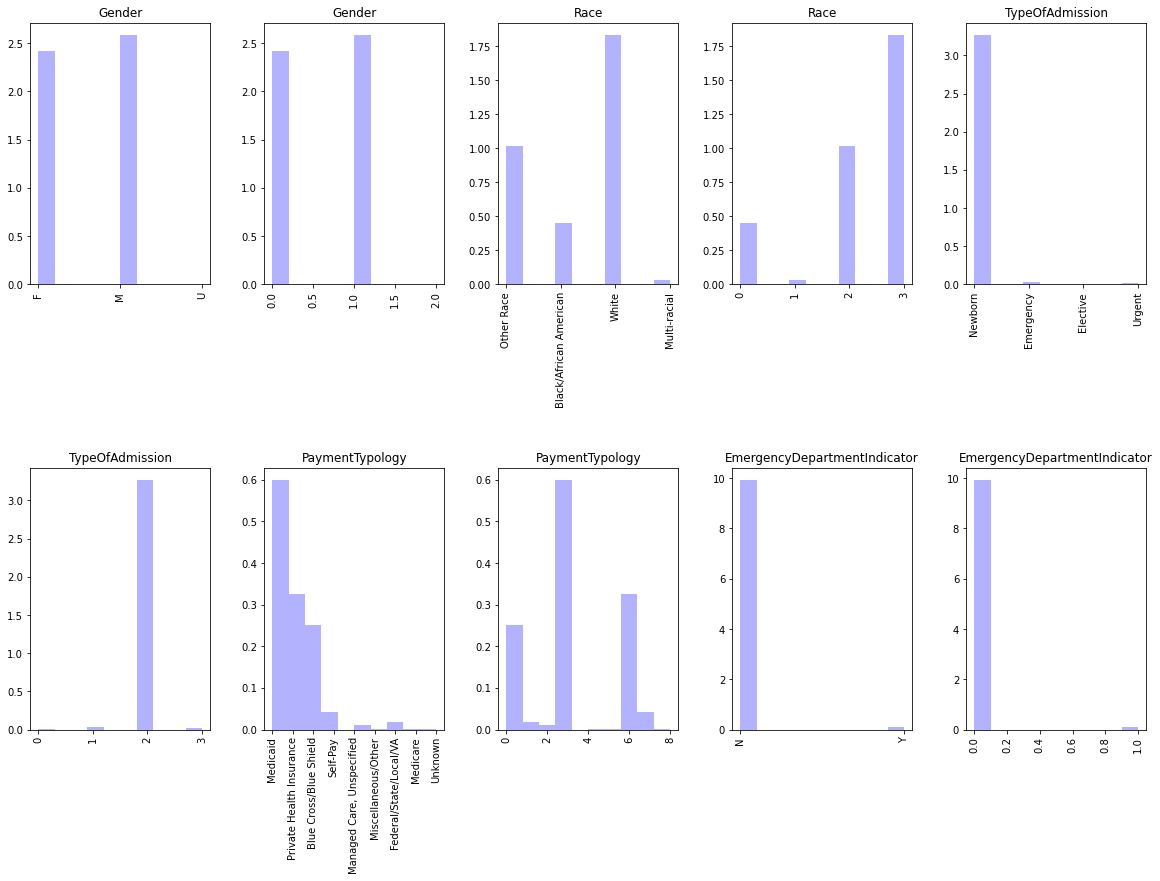

In [13]:
# Print non numeric categorical fields, to show the transformation.
str_category_features = ["Gender", "Race", "TypeOfAdmission", "PaymentTypology", "EmergencyDepartmentIndicator"]
data_X = patients_X.copy()

plt.figure(figsize=(20,20))
for i, name in enumerate(str_category_features):
    
    # Before
    hist_plot(name, [patients_X[name]], ['b'], 3, 5, (i*2)+1)
    
    # Transform each unique value into a unique index. Assigning a unique numeric id to each category.
    data_X[name] = np.unique(patients_X[name], return_inverse=True)[1]
    
    # After
    hist_plot(name, [data_X[name]], ['b'], 3, 5, (i*2)+2)  


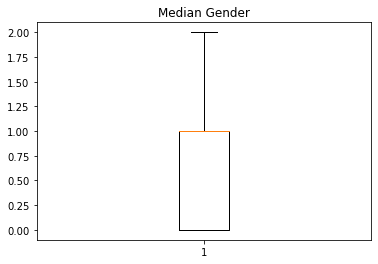

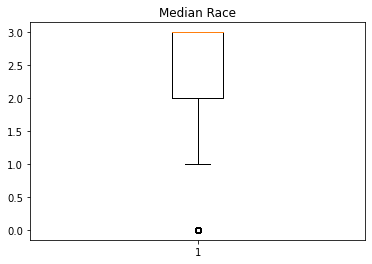

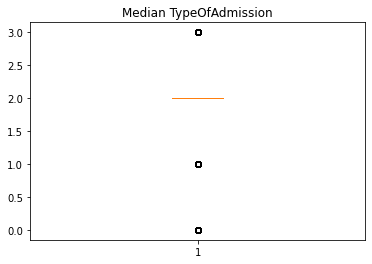

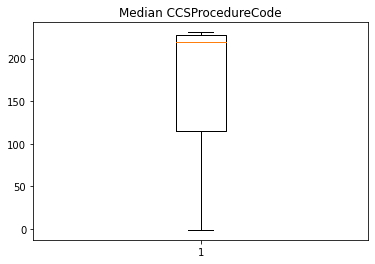

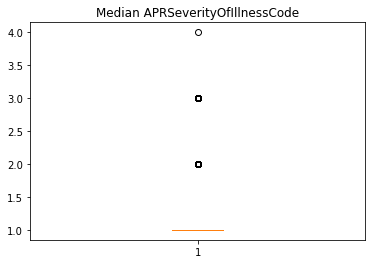

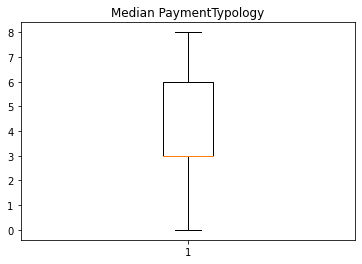

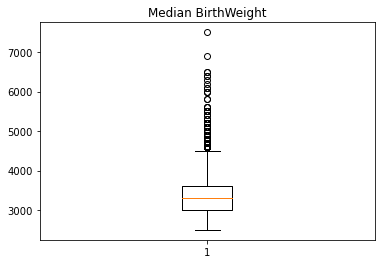

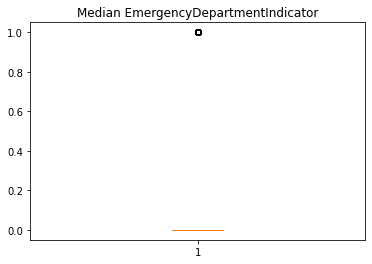

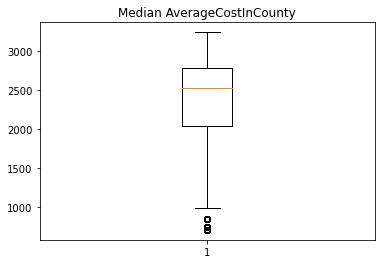

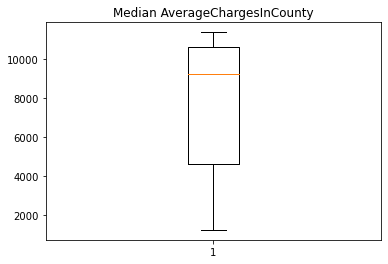

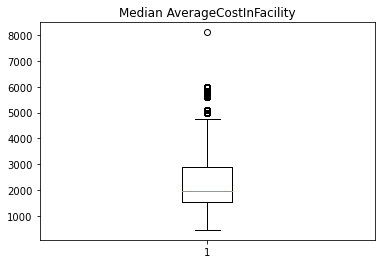

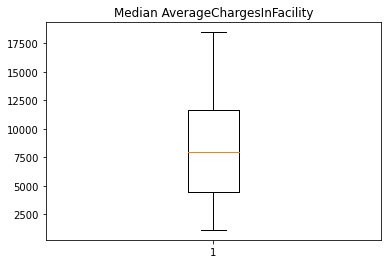

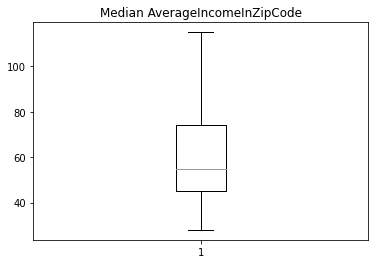

In [8]:
for i, col in enumerate(data_X.columns):
    plt.boxplot(numerical_data_X[col])
    plt.title('Median ' + col)
    plt.show()

> <span style="font-size:1em;">✔</span> **Observations:**
> - sf
> -
> -
> -
> -
>

##### Splitting the dataset
There are many ways to split the data set. A comparison is made between two variants: Hold out & K-fold.

#### Hold out

In [14]:
# Split the Data by 20%
with pd.option_context('mode.chained_assignment', None):
    patients_X_train, patients_X_test, patients_y_train, patients_y_test = train_test_split(data_X, patients_Y, test_size=0.2, shuffle=True)

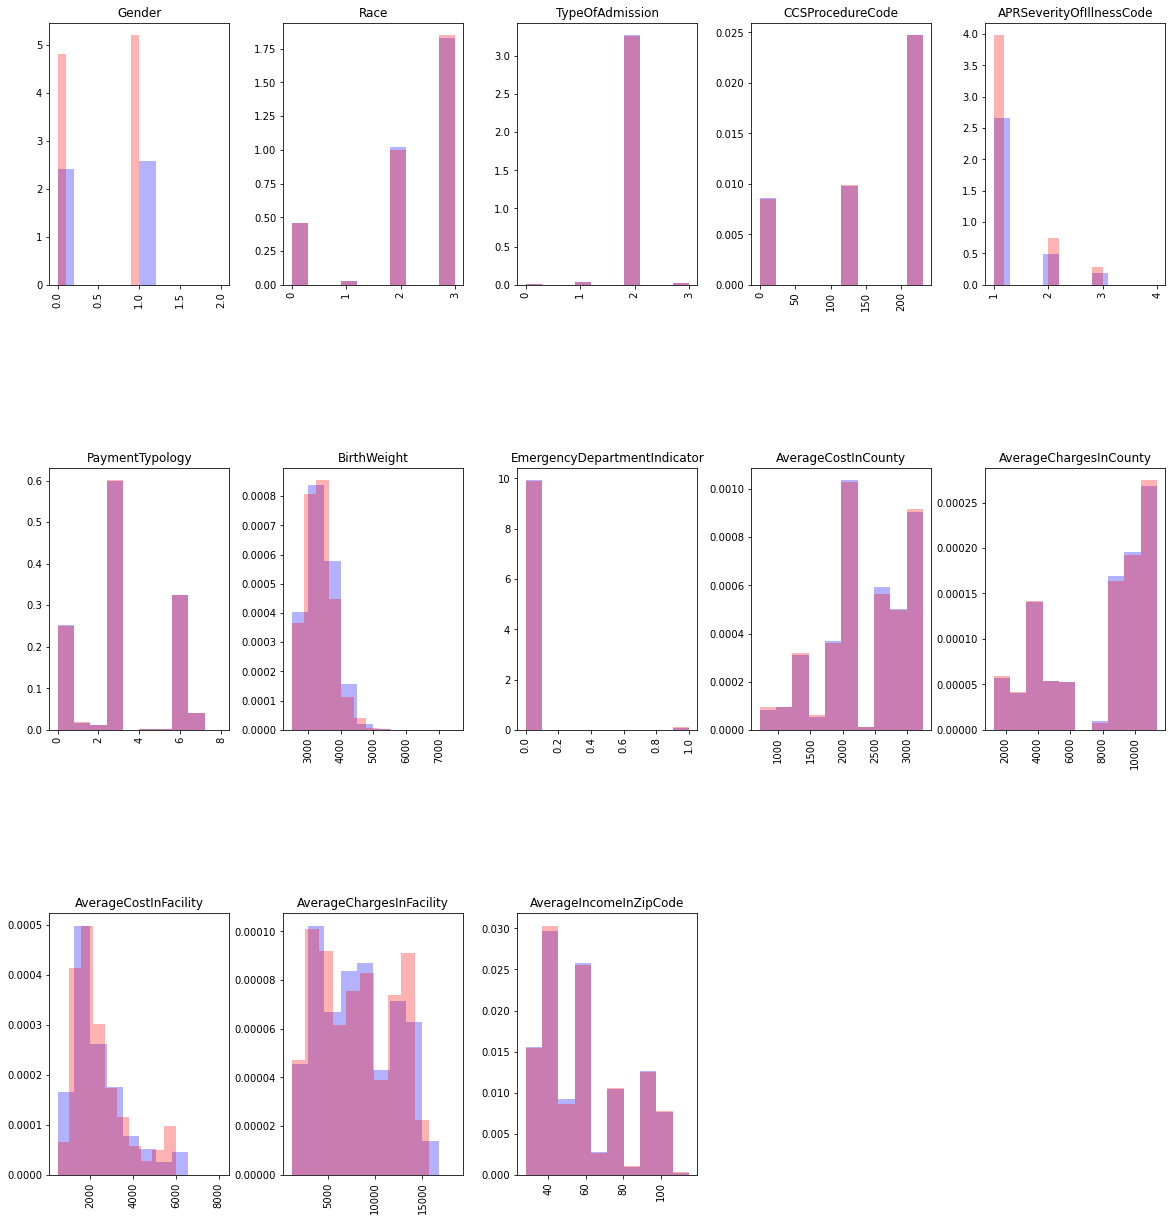

In [15]:
# EDA
plt.figure(figsize=(20,20))
for i, col in enumerate(patients_X_train.columns):
    hist_plot(col, [patients_X_train[col], patients_X_test[col]], ['b', 'r'], 3, 5, i+1)

> <span style="font-size:1em;">✔</span> **Observations:**
> - The data seems to be fairly evenly distributed but could be better
> - <span style="font-size:1.5em;">⚠</span> Gender has different categories between it's train and test sets. Train has 2 categories, and Test has 3. This has occured from 1 of the categories containing an abnormally small number of results and during the splitting process, one set contains all of the results for that category.


#### Correcting training and test sets.
It is important to characterize what are normal and abnormal observations in the data.

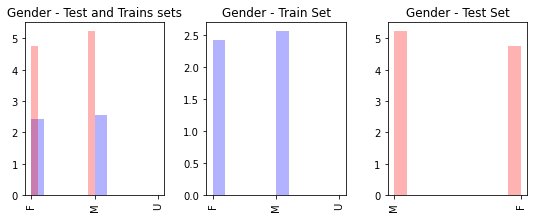

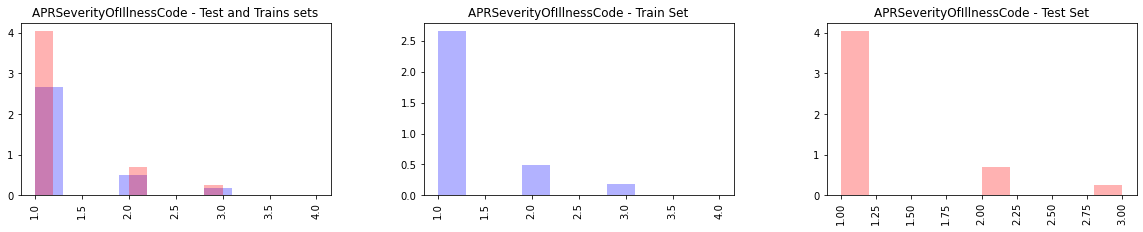

In [11]:
plt.figure(figsize=(9,3))
hist_plot("Gender - Test and Trains sets", [patients_X_train["Gender"], patients_X_test["Gender"]], ['b', 'r'], 1, 3, 1)
hist_plot("Gender - Train Set", [patients_X_train["Gender"]], ['b'], 1, 3, 2)
hist_plot("Gender - Test Set", [patients_X_test["Gender"]], ['r'], 1, 3, 3)

plt.figure(figsize=(20,3))
hist_plot("APRSeverityOfIllnessCode - Test and Trains sets", [patients_X_train["APRSeverityOfIllnessCode"], patients_X_test["APRSeverityOfIllnessCode"]], ['b', 'r'], 1, 3, 1)
hist_plot("APRSeverityOfIllnessCode - Train Set", [patients_X_train["APRSeverityOfIllnessCode"]], ['b'], 1, 3, 2)
hist_plot("APRSeverityOfIllnessCode - Test Set", [patients_X_test["APRSeverityOfIllnessCode"]], ['r'], 1, 3, 3)


# Questions to Answer
What is the range of some of the attributes?
Which of the features have a very different average to the others?
Which feature is skewed (hint examine the histogram)?
Which features are highly correlated?

### Approach
##### Requirements & Restrictions for this project
To start off there were some requirements and restrictions for project:
xcv

##### Data Exploration
Ordinal categorical features
Nominal categorical features

Continuous Numerical features - Decimal
Discrete numerical features - Integers
##### Evaluation Framework

##### Methodology Selection

##### Hyper Parameter Selection Strategy
Random method, graph method, or the
##### Model Analyses


### Ultimate Judgment & Analysis

